EE219 Project 3: Recommender Systems
====================================

# Dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

links = pd.read_csv("Synthetic_Movie_Lens/links.csv")
movies = pd.read_csv("Synthetic_Movie_Lens/movies.csv")
ratings = pd.read_csv("Synthetic_Movie_Lens/ratings.csv")
tags = pd.read_csv("Synthetic_Movie_Lens/tags.csv")

In [2]:
# sparsity of rating dataset

sparsity = ratings.shape[0] / (movies.shape[0]*ratings['userId'].max())
print(sparsity)

0.016968273253211548


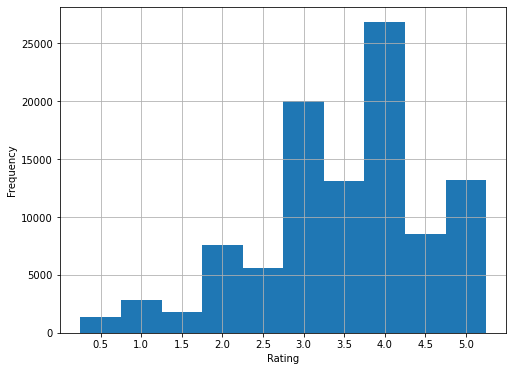

In [3]:
# histogram of rating values

f = ratings['rating'].hist(bins=np.arange(0,5.5,0.5)+0.25, figsize=(8,6))
plt.xticks(np.arange(0.5,5.5,0.5))
f.set_xlabel('Rating')
f.set_ylabel('Frequency')
plt.show()

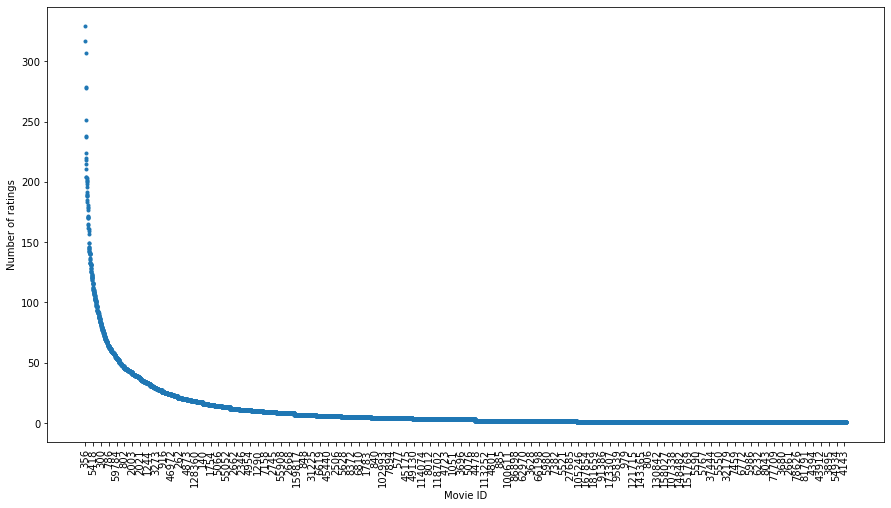

In [4]:
# distribution of number of ratings among movies

# print(ratings.movieId.nunique()) # all movies are included in ratings dataframe

df = ratings.groupby(['movieId']).count().sort_values(['rating'], ascending=False)['rating']

plt.figure(figsize=(15, 8))
plt.scatter(np.arange(df.values.size), df.values, marker='.')
plt.xticks(np.arange(df.values.size/100)*100, df.index[::100], rotation='vertical')
plt.xlabel('Movie ID')
plt.ylabel('Number of ratings')
plt.show()

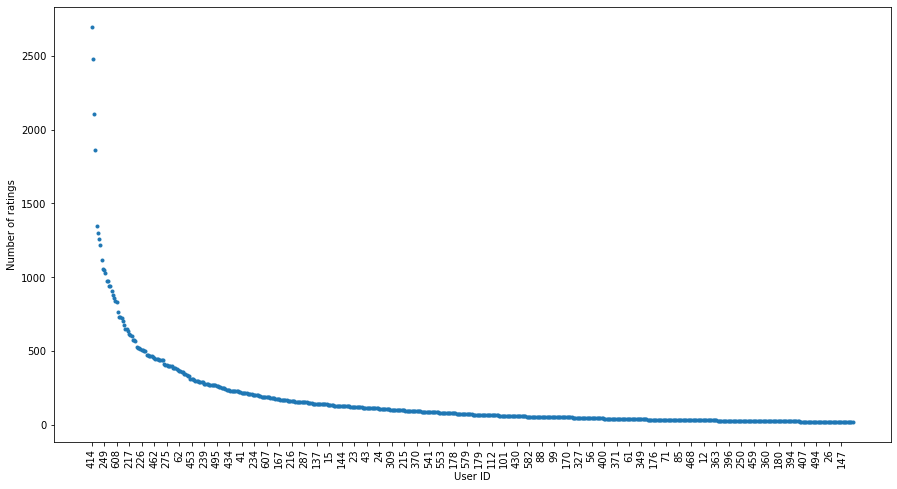

In [5]:
# distribution of number of ratings among users

df = ratings.groupby(['userId']).count().sort_values(['rating'], ascending=False)['rating']

plt.figure(figsize=(15, 8))
plt.scatter(np.arange(df.values.size), df.values, marker='.')
plt.xticks(np.arange(df.values.size/10)*10, df.index[::10], rotation='vertical')
plt.xlabel('User ID')
plt.ylabel('Number of ratings')
plt.show()

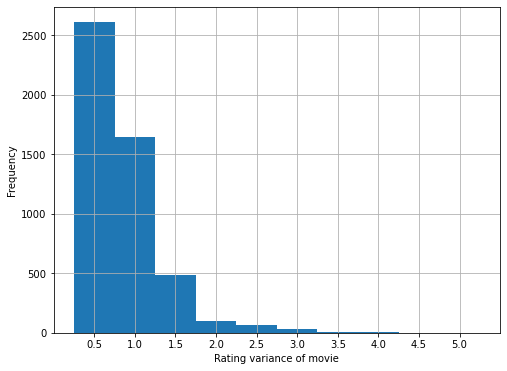

In [6]:
rating_var = ratings.groupby('movieId')['rating'].var(ddof=0) # ddof=0 to avoid NaN when a movie has only 1 rating
f = rating_var.hist(bins=np.arange(0,5.5,0.5)+0.25, figsize=(8,6))
plt.xticks(np.arange(0.5,5.5,0.5))
f.set_xlabel('Rating variance of movie')
f.set_ylabel('Frequency')
plt.show()

**Question 1**:

A. The total number of available ratings is 100836, and the total number of possible ratings is the number of users (610) multiplied by the number of movies (9742), so the sparsity of the rating dataset is 0.0170.

B. The histogram of the frequency of rating values is plotted above. The histogram shows that 3 and 4 star ratings occur most frequently, and far fewer movies are rated 1.5 stars or lower.

C. The distribution of number of ratings among movies is plotted above.

D. The distribution of number of ratings among user is plotted above.

E. The distributions in C and D first decrease steeply then plateau to zero, with a small number of movies receiving the vast majority of ratings, and, similarly, a small number of users giving the vast majority of ratings. Most movies receive much fewer ratings, and most users give much fewer ratings. These distributions show that the ratings matrix is very sparse, which poses a challenge in recommender systems.

F. The histogram of the variance of rating values received by each movie is plotted above. The histogram shows that most movies have low variance, 0.5, and the frequency decreases as variance increases, with very few movies having high rating variance.

# Neighborhood-based collaborative filtering

## Pearson-correlation coefficient

**Question 2**:

A. $\mu_u=\frac{1}{|I_u|}\sum\limits_{k\in I_u}r_{uk}$

B. $I_u \cap I_v$ is the set of item indices for which ratings have been specified by both user $u$ and user $v$. This represents all items rated by both users. $I_u \cap I_v$ can be the empty set when the two users have not rated any of the same items, so no items have received ratings from both user $u$ and user $v$.

## Prediction function

**Question 3**: Any user $v$ may have a predisposition to rate items highly or to rate items poorly, so all their ratings may be centered at a nonzero mean. The prediction function removes this bias per user by centering the ratings, since the relative rating of one item compared to ratings by the same user for other items is what is useful for making predictions about the item.

## K-NN collaborative filter

In [ ]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

reader = Reader(rating_scale=(0.5,5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

k_list = np.arange(2,102,2)
rmse_list = []
mae_list = []
sim_options = {'name': 'pearson', 'min_support': 1}
for k in k_list:
    algo = KNNWithMeans(k=k, sim_options=sim_options, verbose=False)
    cv = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, n_jobs=-1, verbose=False)
    mae_list.append(np.average(cv['test_mae']))
    rmse_list.append(np.average(cv['test_rmse']))

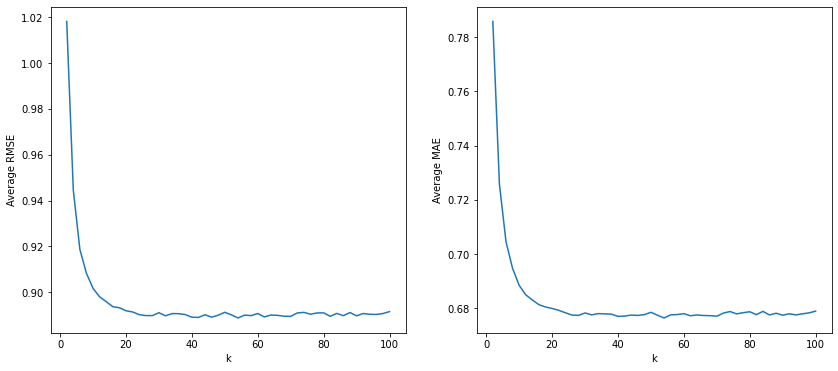

In [41]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(k_list, rmse_list)
ax2.plot(k_list, mae_list)
ax1.set_xlabel('k')
ax1.set_ylabel('Average RMSE')
ax2.set_xlabel('k')
ax2.set_ylabel('Average MAE')
plt.show()

**Question 4**: The plots of average RMSE and MAE over $k$ are shown above.

**Question 5**: The 'minimum $k$' is approximately 20, because beyong $k=20$, the average RMSE and MAE begin converge to a steady-state value of approximately 0.89 and 0.68, respectively.

## Filter performance on trimmed test set

In [84]:
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_pred, title="ROC", ax=None):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    ax = ax or plt.gca()
    line = ax.plot(fpr, tpr, lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    ax.legend(loc="lower right")

    return line
    
def trim(fullset, testset, trim_option):
    test_df = pd.DataFrame(testset, columns =['userId', 'movieId', 'rating'])
    counts_df = fullset.groupby('movieId').count()
    if trim_option == 'popular':
        popular_ids = counts_df[counts_df['rating']>2].index # movieIds of popular movies
        trim_df = test_df[test_df['movieId'].isin(popular_ids)] # trimmed test df with only popular movies
    elif trim_option == 'unpopular':
        trim_df = test_df[test_df['movieId'].isin(counts_df[counts_df['rating']<=2].index)]
    else:
        rating_var = fullset.groupby('movieId')['rating'].var(ddof=0)
        var_ids = rating_var[rating_var>=2].index
        trim_df = test_df[test_df['movieId'].isin(var_ids)]

    trimset = list(trim_df.to_records(index=False)) # convert to list to match testset format
    return trimset

Best k and minimum average RMSE for popular test set: 44, 0.8556455003237818
Best k and minimum average RMSE for unpopular test set: 40, 0.95227186504069
Best k and minimum average RMSE for high_var test set: 98, 1.4777076422125546


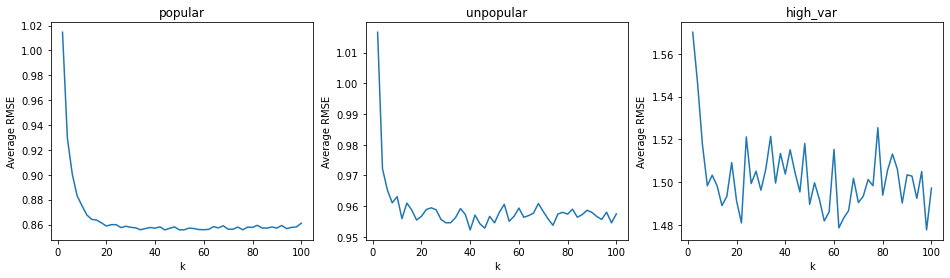

In [188]:
# average RMSE against k for each trimmed test set

from surprise import accuracy
from surprise.model_selection import KFold

trim_options = ['popular', 'unpopular', 'high_var']
fig = plt.figure(figsize=(16,4))

for i, trim_option in enumerate(trim_options):
    k_list = np.arange(2,102,2)
    avg_rmse_list = []

    for k in k_list:
        fold_rmse_list = []
        sim_options = {'name': 'pearson', 'min_support': 1}
        algo = KNNWithMeans(k=k, sim_options=sim_options, verbose=False)
        
        kf = KFold(n_splits=10)
        for trainset, testset in kf.split(data):
            algo.fit(trainset) # train
            trimtest = trim(ratings, testset, trim_option=trim_option) # trim
            predictions = algo.test(trimtest) # predict
            fold_rmse_list.append(accuracy.rmse(predictions, verbose=False)) # compute RMSE
            
        avg_rmse_list.append(np.average(fold_rmse_list)) # avg for each k

    # RMSE for each trim
    print('Minimum average RMSE for {} test set: {}'.format(trim_option, np.min(avg_rmse_list)))
    # k_best.append(k_list[np.argmin(avg_rmse_list)])

    ax = fig.add_subplot(int('13'+str(i+1)))
    ax.plot(k_list, avg_rmse_list)
    ax.set_xlabel('k')
    ax.set_ylabel('Average RMSE')
    ax.set_title(trim_option)

plt.show()

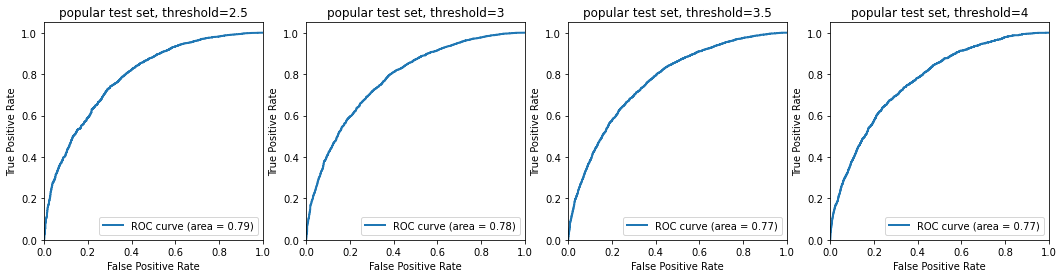

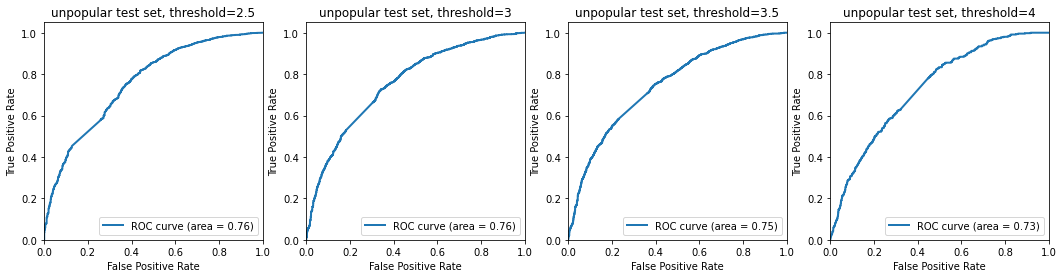

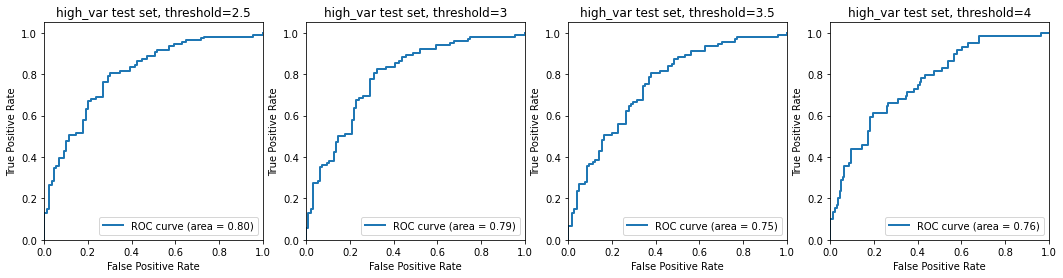

In [233]:
# ROC for best k for each threshold for each trimmed test set

from surprise.model_selection import train_test_split
from sklearn.preprocessing import Binarizer

thresholds = [2.5,3,3.5,4]
k_best = [34,40,22]

for i, trim_option in enumerate(trim_options):
    fig = plt.figure(figsize=(18,4))

    trainset, testset = train_test_split(data, test_size=0.1) # split 90/10

    algo = KNNWithMeans(k=k_best[i], sim_options=sim_options, verbose=False).fit(trainset) # train
    trimtest = trim(ratings, testset, trim_option=trim_option) # trim
    predictions = algo.test(trimtest) # predict

    true_ratings = np.array([pred.r_ui for pred in predictions])[:,np.newaxis]
    est_ratings = np.array([pred.est for pred in predictions])[:,np.newaxis]

    for j, threshold in enumerate(thresholds):
        y_true = Binarizer(threshold=threshold).transform(true_ratings)
        y_pred = est_ratings
    
        ax = fig.add_subplot(int('14'+str(j+1)))
        ax = plot_roc(y_true, y_pred, title="{} test set, threshold={}".format(trim_option, threshold), ax=ax)

    plt.show()

**Question 6**: The average RMSE plotted against $k$ evaluated using 10-fold cross validation for each trimmed test set is shown above. The minimum average RMSE for the popular, unpopular, and high-variance test sets were 0.8556, 0.9523, and 1.4778, respectively.

The ROC curves for each threshold value in [2.5,3,3.5,4] for each trimmed test set are also shown above, along with their AUC values.

# Model-based collaborative filtering

## Non-negative matrix factorization (NMF)

**Question 7**: The problem given by equation 5 is not convex since the objective function varies over both U and V.

Let $U=\begin{bmatrix}
u_1^T\\
\vdots\\
u_m^T
\end{bmatrix}, V=\begin{bmatrix}
v_1^T\\
\vdots\\
v_n^T
\end{bmatrix}$

Then $$(UV^T)_{ij} = u_i^Tv_j$$

For a fixed U, the objective function in the optimization problem given by equation 5 becomes
$$f(V) = \sum_{i=1}^{m}\sum_{j=1}^{n}W_{ij}(r_{ij}-u_i^Tv_j)^2$$

Let $$A = \begin{bmatrix}
W_{11}u_1^T & 0 & 0 & ... & 0 \\
0 & W_{12}u_1^T & 0 & ... & 0 \\
&  & \vdots \\ 
W_{12}u_2^T & 0 & 0 & ... & 0 \\
& & \vdots \\
0 & 0 & 0 & ... & W_{mn}u_m^T
\end{bmatrix}, \tilde{V}=\begin{bmatrix}
v_1\\
\vdots\\
v_n
\end{bmatrix}, b=\begin{bmatrix}
W_{11}r_{11} \\
\vdots \\
W_{1n}r_{1n} \\
W_{2n}r_{2n} \\
\vdots \\
W_{mn}r_{mn} \end{bmatrix}$$

Then the objective function can be formulated as a least squares problem given by
$$f(V) = ||A\tilde{V}-b||_2^2$$

In [235]:
from surprise import NMF

k_list = np.arange(2,52,2)
rmse_list = []
mae_list = []

for k in k_list:
    algo = NMF(n_factors=k)
    cv = cross_validate(algo, data, measures=['RMSE','MAE'], cv=10, n_jobs=-1, verbose=False)
    mae_list.append(np.average(cv['test_mae']))
    rmse_list.append(np.average(cv['test_rmse']))

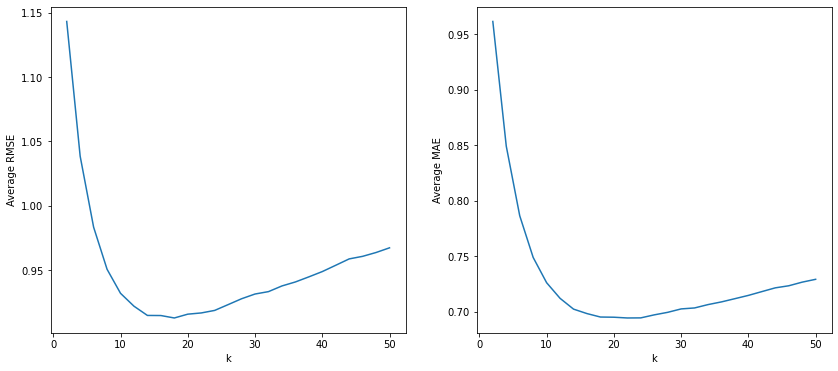

In [236]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(k_list, rmse_list)
ax2.plot(k_list, mae_list)
ax1.set_xlabel('k')
ax1.set_ylabel('Average RMSE')
ax2.set_xlabel('k')
ax2.set_ylabel('Average MAE')
plt.show()

In [241]:
print("Minimum average RMSE at k={}: {}".format(k_list[np.argmin(rmse_list)], np.min(rmse_list)))
print("Minimum average MAE at k={}: {}".format(k_list[np.argmin(mae_list)], np.min(mae_list)))

Minimum average RMSE at k=18: 0.9128109863844726
Minimum average MAE at k=22: 0.6942981348436864


Minimum average RMSE for popular test set: 0.8728566845744977
Minimum average RMSE for unpopular test set: 0.9912406701897138
Minimum average RMSE for high_var test set: 1.4915434215547505


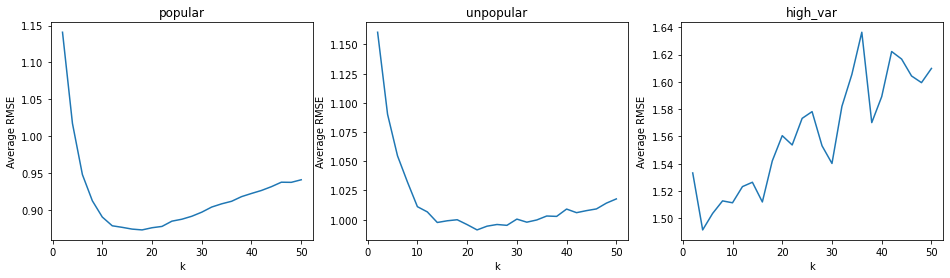

In [242]:
# average RMSE against k for each trimmed test set

trim_options = ['popular', 'unpopular', 'high_var']
fig = plt.figure(figsize=(16,4))

for i, trim_option in enumerate(trim_options):
    k_list = np.arange(2,52,2)
    avg_rmse_list = []

    for k in k_list:
        fold_rmse_list = []
        algo = NMF(n_factors=k)
        
        kf = KFold(n_splits=10)
        for trainset, testset in kf.split(data):
            algo.fit(trainset) # train
            trimtest = trim(ratings, testset, trim_option=trim_option) # trim
            predictions = algo.test(trimtest) # predict
            fold_rmse_list.append(accuracy.rmse(predictions, verbose=False)) # compute RMSE
            
        avg_rmse_list.append(np.average(fold_rmse_list)) # avg for each k

    # RMSE for each trim
    print('Minimum average RMSE for {} test set: {}'.format(trim_option, np.min(avg_rmse_list)))

    ax = fig.add_subplot(int('13'+str(i+1)))
    ax.plot(k_list, avg_rmse_list)
    ax.set_xlabel('k')
    ax.set_ylabel('Average RMSE')
    ax.set_title(trim_option)

plt.show()

In [ ]:
# ROC with best k for each threshold for each trimmed test set

thresholds = [2.5,3,3.5,4]
k_best = 18

for trim_option in trim_options:
    fig = plt.figure(figsize=(18,4))

    trainset, testset = train_test_split(data, test_size=0.1) # split 90/10

    algo = NMF(n_factors=k_best).fit(trainset) # train
    trimtest = trim(ratings, testset, trim_option=trim_option) # trim
    predictions = algo.test(trimtest) # predict

    true_ratings = np.array([pred.r_ui for pred in predictions])[:,np.newaxis]
    est_ratings = np.array([pred.est for pred in predictions])[:,np.newaxis]

    for j, threshold in enumerate(thresholds):
        y_true = Binarizer(threshold=threshold).transform(true_ratings)
        y_pred = est_ratings
    
        ax = fig.add_subplot(int('14'+str(j+1)))
        ax = plot_roc(y_true, y_pred, title="{} test set, threshold={}".format(trim_option, threshold), ax=ax)

    plt.show()

**Question 8**:

A. The plots of average RMSE and MAE over $k$ are shown above.

B. Based on the plots, the optimal number of latent factors is in the range of 18 to 22. $k=18$ achieves the minimum average RMSE of 0.9128, and $k=22$ achieves the minimum average MAE of 0.6943. There are 19 distinct movie genres (including none listed), which is similar to the optimal number of latent factors.

C. The average RMSE plotted against $k$ evaluated using 10-fold cross validation for each trimmed test set is shown above. The minimum average RMSE for the popular, unpopular, and high-variance test sets were 0.8729, 0.9912, and 1.4915, respectively.

The ROC curves for each threshold value in [2.5,3,3.5,4] for each trimmed test set are also shown above, along with their AUC values. $k=18$ was used as the optimal number of latent factors found in question B.

In [23]:
reader = Reader(rating_scale=(0.5,5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader).build_full_trainset()

algo = NMF(n_factors=20).fit(data)
U = algo.pu
V = algo.qi

In [39]:
V_idx = np.argsort(V, axis=0)[-1:-11:-1] # sorted indices of top 10 movies per column
V_idx

array([[1508, 1632, 5681, 3317, 5325, 5342, 2605, 5342, 8206, 4712, 9248,
        6637, 5207, 3232, 1218, 7886, 2880, 5698,  743, 8187],
       [3794, 4383, 6256, 4678, 5085, 1172, 3200, 5524, 3466, 2974, 1702,
        7246, 5961, 4019, 1562, 6034, 2731, 2857, 4251, 1200],
       [4850, 4324, 2131, 1384, 1054, 4995, 7753, 2984, 2551, 4782, 2798,
        9339, 8449, 4507, 3010, 8478, 8598, 1891, 4800, 5320],
       [3195, 2410, 3415, 3792, 3459, 1334, 3687, 1157, 6199, 3466, 6669,
        7335,  678, 1719, 7886, 2473, 3014, 4764, 4404, 6052],
       [3811, 7246, 5599, 3261, 5549, 6561, 4621, 7889, 3356, 3012, 2375,
         189, 4469, 8814, 2655, 3777, 8667, 3306, 4968,  507],
       [6951, 6951, 5325, 6533, 4070, 1677, 7657, 3392,  835, 5663, 7523,
        6787,  762, 4431, 4707, 7133, 6602, 2367, 2333, 1376],
       [1931, 1157, 2272, 4575, 3535, 4035, 1964,  368, 3960, 8206, 4183,
         745, 6199, 1941, 6232,  337, 1049, 4281, 2546, 4516],
       [4339, 7705, 7234, 4762, 7830, 658

In [78]:
# genres of top 10 movies in each column

for i in np.arange(20):
    top_movieId = ratings['movieId'].iloc[V_idx[:,i]] # movieIds of top 10 movies per column
    movieId_idx = movies.set_index('movieId') # index movies df by movieId
    print('Latent factor: {}'.format(i))
    print(movieId_idx[movieId_idx.index.isin(top_movieId)].reindex(top_movieId)['genres'].values)

Latent factor: 0
['Comedy|Romance' 'Drama|Romance|War|Western' 'Comedy|Drama'
 'Comedy|Crime' 'Comedy|Drama' 'Action' 'Action|Drama|Sci-Fi'
 'Adventure|Animation|Children|Fantasy|Musical' 'Crime|Drama'
 'Animation|Children|Comedy|Crime']
Latent factor: 1
['Action|Adventure|Sci-Fi' 'Adventure|Animation|Children|Drama'
 'Comedy|Fantasy|Romance' 'Children|Comedy' 'Action|Crime|Thriller'
 'Action' 'Comedy|Romance' 'Adventure|Animation|Children|Comedy|Fantasy'
 'Drama|Romance' 'Adventure|Animation|Children|Comedy|Fantasy|IMAX']
Latent factor: 2
['Adventure|Children|Drama' 'Adventure|Animation|Children|Comedy|Sci-Fi'
 'Action|Fantasy|Horror|Thriller' 'Animation|Children|Fantasy|Musical'
 'Animation|Children|Comedy' 'Documentary' 'Action|Comedy|Western'
 'Action|Adventure|Sci-Fi' 'Drama|Mystery|Sci-Fi|Thriller'
 'Action|Adventure']
Latent factor: 3
['Horror|Thriller' 'Comedy' 'Action|Adventure|Sci-Fi' 'Drama|Romance'
 'Comedy' 'Crime|Drama|Thriller' 'Action|Drama|Thriller|War'
 'Action|Advent

**Question 9**: The genres for the top 10 movies for each latent factor are shown above. Each latent factor appears to represent a collection of a few primary genres. For example, the first latent factor includes several movies in the comedy and drama genres; the second latent factor includes movies in the adventure, children, and comedy genres; and the third latent factor includes primarily spans the action, adventure, and children genres. The latent factors represent a unique subset of movie genres, while the genres appear in multiple latent factors.

## Matrix factorization with bias

In [401]:
from surprise import SVD

reader = Reader(rating_scale=(0.5,5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

k_list = np.arange(2,52,2)
rmse_list = []
mae_list = []

for k in k_list:
    algo = SVD(n_factors=k)
    cv = cross_validate(algo, data, measures=['RMSE','MAE'], cv=10, n_jobs=-1, verbose=False)
    mae_list.append(np.average(cv['test_mae']))
    rmse_list.append(np.average(cv['test_rmse']))

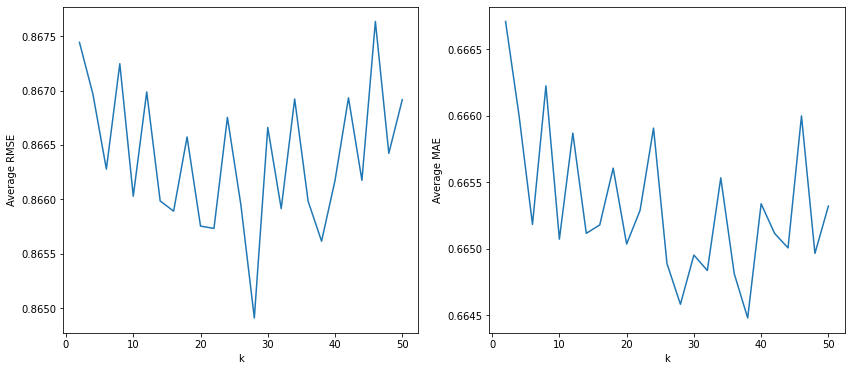

In [402]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(k_list, rmse_list)
ax2.plot(k_list, mae_list)
ax1.set_xlabel('k')
ax1.set_ylabel('Average RMSE')
ax2.set_xlabel('k')
ax2.set_ylabel('Average MAE')
plt.show()

In [403]:
print("Minimum average RMSE at k={}: {}".format(k_list[np.argmin(rmse_list)], np.min(rmse_list)))
print("Minimum average MAE at k={}: {}".format(k_list[np.argmin(mae_list)], np.min(mae_list)))

Minimum average RMSE at k=28: 0.8649079933380314
Minimum average MAE at k=38: 0.6644775097799822


Minimum average RMSE for popular test set: 0.8461755467458882
Minimum average RMSE for unpopular test set: 0.8983594073361625
Minimum average RMSE for high_var test set: 1.4500300349425739


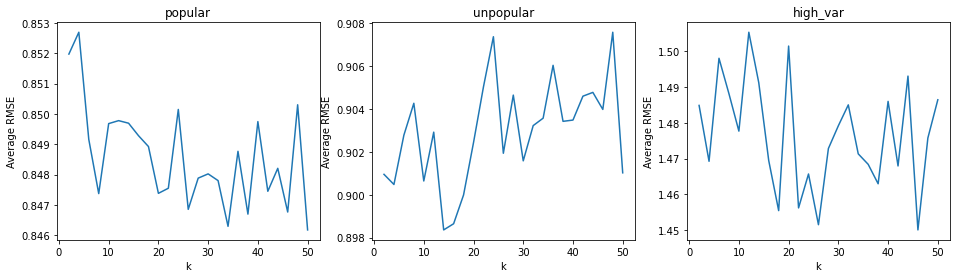

In [551]:
# average RMSE against k for each trimmed test set

trim_options = ['popular', 'unpopular', 'high_var']
fig = plt.figure(figsize=(16,4))

for i, trim_option in enumerate(trim_options):
    k_list = np.arange(2,52,2)
    avg_rmse_list = []

    for k in k_list:
        fold_rmse_list = []
        algo = SVD(n_factors=k)
        
        kf = KFold(n_splits=10)
        for trainset, testset in kf.split(data):
            algo.fit(trainset) # train
            trimtest = trim(ratings, testset, trim_option=trim_option) # trim
            predictions = algo.test(trimtest) # predict
            fold_rmse_list.append(accuracy.rmse(predictions, verbose=False)) # compute RMSE
            
        avg_rmse_list.append(np.average(fold_rmse_list)) # avg for each k

    # RMSE for each trim
    print('Minimum average RMSE for {} test set: {}'.format(trim_option, np.min(avg_rmse_list)))

    ax = fig.add_subplot(int('13'+str(i+1)))
    ax.plot(k_list, avg_rmse_list)
    ax.set_xlabel('k')
    ax.set_ylabel('Average RMSE')
    ax.set_title(trim_option)

plt.show()

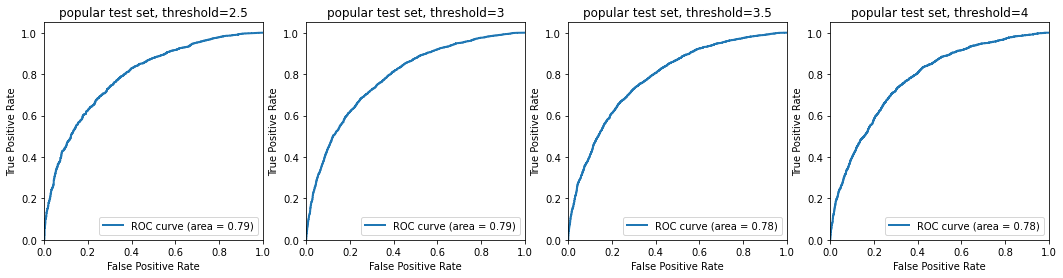

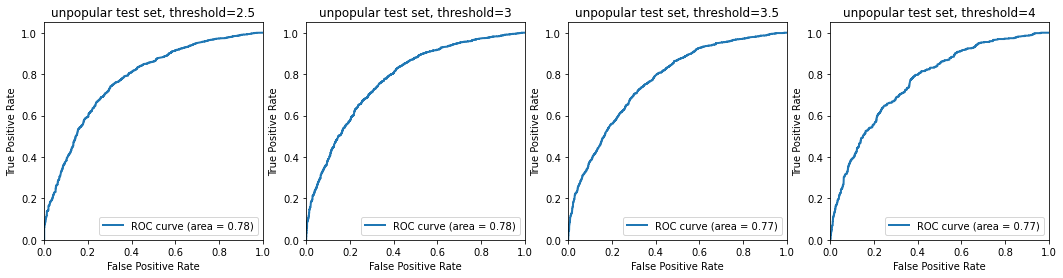

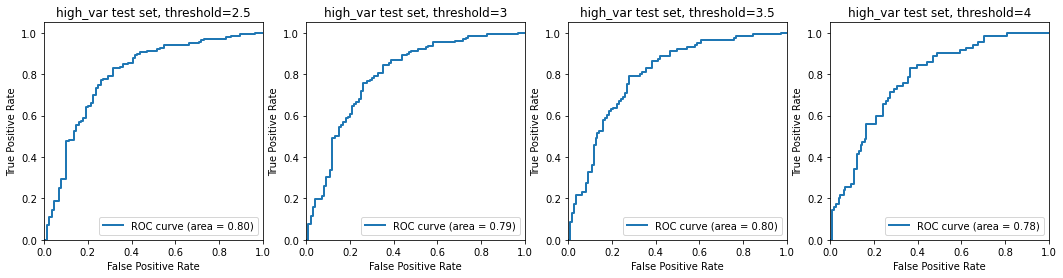

In [553]:
# ROC with best k for each threshold for each trimmed test set

thresholds = [2.5,3,3.5,4]
k_best = 28

for trim_option in trim_options:
    fig = plt.figure(figsize=(18,4))

    trainset, testset = train_test_split(data, test_size=0.1) # split 90/10

    algo = SVD(n_factors=k_best).fit(trainset) # train
    trimtest = trim(ratings, testset, trim_option=trim_option) # trim
    predictions = algo.test(trimtest) # predict

    true_ratings = np.array([pred.r_ui for pred in predictions])[:,np.newaxis]
    est_ratings = np.array([pred.est for pred in predictions])[:,np.newaxis]

    for j, threshold in enumerate(thresholds):
        y_true = Binarizer(threshold=threshold).transform(true_ratings)
        y_pred = est_ratings
    
        ax = fig.add_subplot(int('14'+str(j+1)))
        ax = plot_roc(y_true, y_pred, title="{} test set, threshold={}".format(trim_option, threshold), ax=ax)

    plt.show()

**Question 10**:

A. The plots of average RMSE and MAE over $k$ are shown above.

B. Based on the plots, the optimal number of latent factors is in the range of 28 to 38. $k=28$ achieves the minimum average RMSE of 0.8649, and $k=38$ achieves the minimum average MAE of 0.6645. This is higher than the number of distinct genres.

C. The average RMSE plotted against $k$ for each trimmed test set is shown above. The minimum average RMSE for the popular, unpopular, and high-variance test sets were 0.8461, 0.8984, and 1.4500, respectively.

The ROC curves for each threshold value in [2.5,3,3.5,4] for each trimmed test set are also shown above, along with their AUC values. $k=28$ was used as the optimal number of latent factors found in question B.

# Naive collaborative filtering

In [136]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

user_means = ratings.groupby('userId')['rating'].mean()
kf = KFold(n_splits=10)
mf_rmse = 0

for train_idx, test_idx in kf.split(ratings):
    X_train = ratings.iloc[train_idx]
    X_test = ratings.iloc[test_idx]
    y_pred = [user_means[userId] for userId in X_test['userId']] # predict
    y_true = X_test['rating']
    mf_rmse += mean_squared_error(y_true, y_pred, squared=False) # compute RMSE
mf_rmse /= 10
print(mf_rmse)

0.9347086488068349


In [187]:
# avg rmse on each trim test set

trim_options = ['popular', 'unpopular', 'high_var']

for trim_option in trim_options:
    mf_rmse = 0
    kf = KFold(n_splits=10)

    for train_idx, test_idx in kf.split(ratings):
        X_train = ratings.iloc[train_idx]
        X_test = ratings.iloc[test_idx]
        testset = X_test[['userId', 'movieId', 'rating']].to_numpy()
        trimtest = trim(ratings, testset, trim_option=trim_option) # trim
        trimtest = pd.DataFrame.from_records(trimtest, columns=['userId', 'movieId', 'rating'])
        
        y_pred = [user_means[userId] for userId in trimtest['userId']] # predict
        y_true = trimtest['rating']
        mf_rmse += mean_squared_error(y_true, y_pred, squared=False) # compute RMSE
    print('Average RMSE for {} trimming: {}'.format(trim_option, mf_rmse / 10))


Average RMSE for popular trimming: 0.9227889242471592
Average RMSE for unpopular trimming: 0.9600618948251661
Average RMSE for high_var trimming: 1.5042725349155792


**Question 11**:

* The average RMSE across all 10 folds is 0.9347.

* The average RMSE across all 10 folds for the popular, unpopular, and high-variance test sets are 0.9228, 0.9601, and 1.5043, respectively.

# Performance comparison

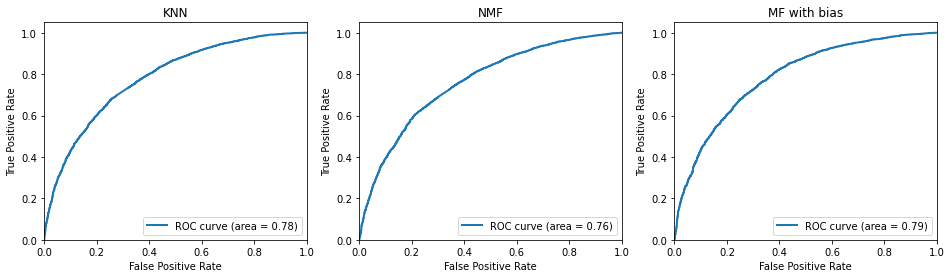

In [554]:
threshold = 3

knn_k = 20
nmf_k = 18
mf_k = 28

sim_options = {'name': 'pearson', 'min_support': 1}
knn_algo = KNNWithMeans(k=knn_k, sim_options=sim_options, verbose=False)
nmf_algo = NMF(n_factors=nmf_k)
mf_algo = SVD(n_factors=mf_k)

algos = [knn_algo, nmf_algo, mf_algo]
algo_names = ['KNN', 'NMF', 'MF with bias']

fig = plt.figure(figsize=(16,4))

reader = Reader(rating_scale=(0.5,5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.1) # split 90/10

for i, algo in enumerate(algos):
    algo.fit(trainset) # train
    predictions = algo.test(testset) # predict

    true_ratings = np.array([pred.r_ui for pred in predictions])[:,np.newaxis]
    est_ratings = np.array([pred.est for pred in predictions])[:,np.newaxis]
    
    y_true = Binarizer(threshold=threshold).transform(true_ratings)
    y_pred = est_ratings

    ax = fig.add_subplot(int('13'+str(i+1)))
    ax = plot_roc(y_true, y_pred, title=algo_names[i], ax=ax)

plt.show()

**Question 12**: The ROC curves for the k-NN, NMF, and MR with bias collaborative filters are plotted above. The ROC curve for k-NN has an AUC of 0.78, the ROC curve for NMF has an AUC of 0.76, and the MF with bias ROC curve has an AUC of 0.79. The figure suggests that the NMF filter has the worst ability of the three models to separate between high and low ratings, while the performance of MF with bias is the best, as it achieves the highest AUC of 0.79.

# Ranking

**Question 13**: Precision is the fraction of true positives out of all predictions, and recall is the fraction of true positives out of all real positives. In the context of recommender systems, recall measures how many of the recommended items were good recommendations (i.e. the recommended item is liked by the user), while recall measures how many of the user's liked items were included in the set of recommendations. Recall will be low when the size of the recommended set is small compared to the size of all liked items, though precision may still be high if recommended items belong in the set of liked items. At the limit of $t=1$, a correct recommendation will achieve a precision of 1 but a recall of $\frac{1}{|G|}$. On the other hand, precision may be worse as $t$ increases, because increasing the size of recommended items can allow some disliked items to be recommended, as the prediction of the items decreases for each additional recommended item. For the extreme of $t=|G|$, precision will be low since all items, including those with low predicted ratings, will be recommended, while recall will be high since $|S(t) \cap G|$ will be comparable to $|G|$.

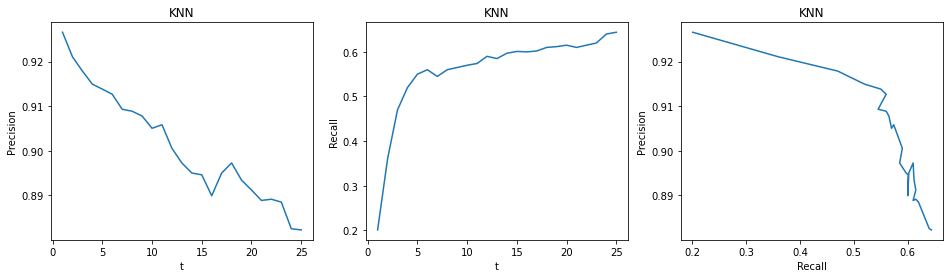

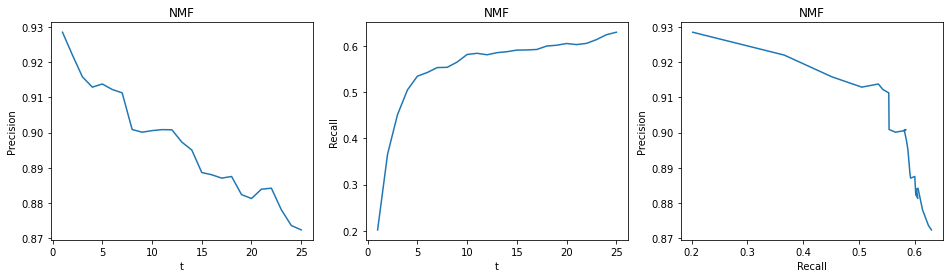

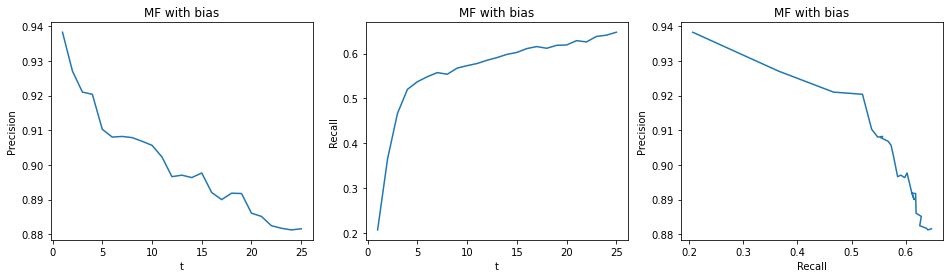

In [552]:
from surprise.model_selection import KFold

threshold = 3

t_list = np.arange(25)+1

reader = Reader(rating_scale=(0.5,5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

precisions = []
recalls = []

algos = [knn_algo, nmf_algo, mf_algo]
algo_names = ['KNN', 'NMF', 'MF with bias']

num_folds = 10
kf = KFold(n_splits=num_folds)
for i, algo in enumerate(algos):
    fig = plt.figure(figsize=(12,4))

    precision_list = []
    recall_list = []

    for t in t_list:
        t_precision = 0
        t_recall = 0

        for trainset, testset in kf.split(data):
            algo.fit(trainset) # train
            predictions = algo.test(testset) # predict
            
            fold_precision = 0
            fold_recall = 0
            
            num_users = len(pd.DataFrame(predictions)['uid'].unique())
            for user in pd.DataFrame(predictions)['uid'].unique():
                G = ratings[(ratings['userId']==user) & (ratings['rating']>=3)]['movieId'].unique() # set of movies liked

                user_preds = [pred for pred in predictions if pred.uid==user and np.isin(pred.iid, G)] # predictions for each user
                
                # drop user if |G|=0 or user has rated less than t items
                if (len(G)==0) or (len(user_preds)<t):
                    num_users -= 1
                    continue
                
                rec_idx = np.argsort([pred.est for pred in user_preds])[::-1][:t] # top t indices of predictions for each user
                S = [user_preds[i].iid for i in rec_idx] # predicted movieIds

                fold_precision += len(set(S) & set(G)) / len(S)
                fold_recall += len(set(S) & set(G)) / len(G)

            # average precision and recall across users for this fold
            fold_precision /= num_users
            fold_recall /= num_users

            t_precision += fold_precision
            t_recall += fold_recall

        
        # average precision and recall across folds for this t
        t_precision /= num_folds
        t_recall /= num_folds

        precision_list.append(t_precision)
        recall_list.append(t_recall)

    # plot precision over t
    ax = fig.add_subplot(121)
    p1 = ax.plot(t_list, precision_list)
    plt.title(algo_names[i])
    plt.xlabel('t')
    plt.ylabel('Precision')

    # plot recall over t
    ax = fig.add_subplot(122)
    p2 = ax.plot(t_list, recall_list)
    plt.title(algo_names[i])
    plt.xlabel('t')
    plt.ylabel('Recall')

    ax = fig.add_subplot(133)
    ax.plot(recall_list, precision_list)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(algo_names[i])
    plt.show()

plt.show()

**Question 14**: The average precision and average recall are plotted above over $t$ for each of the three models. The precision-recall curves for the three models are also shown above. The plots of average precision over $t$ all show a decreasing pattern as $t$ increases, since more errors are made as a larger set of items are recommended to the user. For each model, recall increases with $t$, since the larger recommendation set size allows more liked items to be included in the recommendations. The precision-recall curves for each of the models show this tradeoff, where recall tends to be low for high precision scores, and precision tends to be low for high recall scores. Comparing the three models, the recall scores are similar across $t$, and the MF with bias models achieves the highest precision while k-NN achieves the lowest precision.